### Project 2: Advanced Lane Finding

#### Solutions Outline

1. Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
2. Apply a distortion correction to raw images.
3. Use color transforms, gradients, etc., to create a thresholded binary image.
4. Apply a perspective transform to rectify binary image ("birds-eye view").
5. Detect lane pixels and fit to find the lane boundary.
6. Determine the curvature of the lane and vehicle position with respect to center.
7. Warp the detected lane boundaries back onto the original image.
8. Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

In [151]:
%matplotlib inline

import numpy as np
import cv2
import matplotlib.pyplot as plt
import glob
import pickle

In [2]:
# Constants

chess_dims = (9, 6)

#### Step 1: Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.

In [165]:
def calibrate_camera():
    
    # Shortcut while running again and again, just pick the previously found points
    input_file = open('camera_dist.pkl', 'rb')
    if input_file is not None:
        points = pickle.load(input_file)
        return (points['objpoints'], points['imgpoints'])
    
    # prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
    objp = np.zeros((6*9, 3), np.float32)
    objp[:,:2] = np.mgrid[0:9, 0:6].T.reshape(-1,2)

    # Arrays to store object points and image points from all the images.
    objpoints = [] # 3d points in real world space
    imgpoints = [] # 2d points in image plane.
    
    images = glob.glob('./camera_cal/calibration*.jpg')

    # Step through the list and search for chessboard corners
    for fname in images:
        img = cv2.imread(fname)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

        # Find the chessboard corners
        ret, corners = cv2.findChessboardCorners(img, chess_dims, None)

        # If found, add object points, image points
        if ret == True:
            objpoints.append(objp)
            imgpoints.append(corners)
    
    output_file = open('camera_dist.pkl', 'wb')
    pickle.dump({'objpoints': objpoints, 'imgpoints': imgpoints}, output_file)
    return (objpoints, imgpoints)

#### Step 2: Apply a distortion correction to raw images.

In [30]:
def undistort_image(image, objpoints, imgpoints):  
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    ret, corners = cv2.findChessboardCorners(gray, chess_dims, None)
    image = cv2.drawChessboardCorners(image, chess_dims, corners, ret)
    ret , mtx, dist , rcves , tvecs = cv2.calibrateCamera(objpoints , imgpoints , gray.shape[::-1], None, None)
    return cv2.undistort(image, mtx, dist, None, mtx)

#### Step 3: Magnitude Thresholding

In [86]:
def threshold_image(img, sx_thresh=(0, 255), s_thresh=(0, 255), sobel_kernel=3):
    # Convert to HLS color space and separate the S channel
    # Note: img is the undistorted image
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    s_channel = hls[:,:,2]

    # Grayscale image
    # NOTE: we already saw that standard grayscaling lost color information for the lane lines
    # Explore gradients in other colors spaces / color channels to see what might work better
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

    # Sobel x
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel) # Take the derivative in x
    abs_sobelx = np.absolute(sobelx) # Absolute x derivative to accentuate lines away from horizontal
    scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))

    # Threshold x gradient
    thresh_min = sx_thresh[0]
    thresh_max = sx_thresh[1]
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= thresh_min) & (scaled_sobel <= thresh_max)] = 1

    # Threshold color channel
    s_thresh_min = s_thresh[0]
    s_thresh_max = s_thresh[1]
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= s_thresh_min) & (s_channel <= s_thresh_max)] = 1

    # Stack each channel to view their individual contributions in green and blue respectively
    # This returns a stack of the two binary images, whose components you can see as different colors
    color_binary = np.dstack(( np.zeros_like(sxbinary), sxbinary, s_binary)) * 255

    # Combine the two binary thresholds
    combined_binary = np.zeros_like(sxbinary)
    combined_binary[(s_binary == 1) | (sxbinary == 1)] = 1
    
    return combined_binary

#### Step 4: Apply a perspective transform to rectify binary image ("birds-eye view")

In [142]:
def transform_perspective(img):
    img_size = img.T.shape
    
#     src = np.float32(
#         [[(img_size[0] / 2) - 55, img_size[1] / 2 + 100],
#         [((img_size[0] / 6) - 10), img_size[1]],
#         [(img_size[0] * 5 / 6) + 60, img_size[1]],
#         [(img_size[0] / 2 + 55), img_size[1] / 2 + 100]])
#     dst = np.float32(
#         [[(img_size[0] / 4), 0],
#         [(img_size[0] / 4), img_size[1]],
#         [(img_size[0] * 3 / 4), img_size[1]],
#         [(img_size[0] * 3 / 4), 0]])

    src = np.float32(
        [[268, 697],
        [631, 448],
        [718, 448],
        [1129, 697]])
#     dst = np.float32(
#         [[(img_size[0] / 4), img_size[1]],
#         [(img_size[0] / 4), 0],   
#         [(img_size[0] * 3 / 4), 0],
#         [(img_size[0] * 3 / 4), img_size[1]]])
    dst = np.float32(
        [[268 + 55, img_size[1]],
        [268 + 55, 0],
        [718 - 55, 0],
        [718 - 55, img_size[1]]])
    
    M = cv2.getPerspectiveTransform(src, dst)
    warped = cv2.warpPerspective(img, M, img.T.shape)
    return warped

#### Pipeline

In [166]:
src_img = cv2.imread('./test_images/straight_lines2.jpg')
(opts, ipts) = calibrate_camera()
undistorted = undistort_image(src_img, opts, ipts)
thresholded = threshold_image(undistorted, sx_thresh=(20, 100), s_thresh=(170, 255), sobel_kernel=9)
transformed = transform_perspective(thresholded)

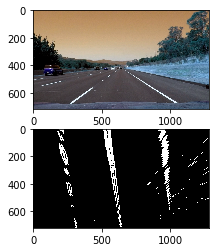

In [163]:
f, axarr = plt.subplots(2)
axarr[0].imshow(src_img)
axarr[1].imshow(transformed, cmap='gray')

ValueError: need at least one array to concatenate

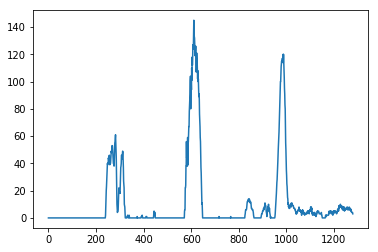

In [171]:
# Grab only the bottom half of the image
# Lane lines are likely to be mostly vertical nearest to the car
bottom_half = transformed[transformed.shape[0]//2:,:]

# Sum across image pixels vertically - make sure to set an `axis`
# i.e. the highest areas of vertical lines should be larger values
histogram = np.sum(bottom_half, axis=0)
    

# Create histogram of image binary activations

# Visualize the resulting histogram
plt.plot(histogram)

# Create an output image to draw on and visualize the result
out_img = np.dstack((transformed, transformed, transformed))*255
# Find the peak of the left and right halves of the histogram
# These will be the starting point for the left and right lines
midpoint = np.int(histogram.shape[0]//2)
leftx_base = np.argmax(histogram[:midpoint])
rightx_base = np.argmax(histogram[midpoint:]) + midpoint

# HYPERPARAMETERS
# Choose the number of sliding windows
nwindows = 9
# Set the width of the windows +/- margin
margin = 100
# Set minimum number of pixels found to recenter window
minpix = 50

# Set height of windows - based on nwindows above and image shape
window_height = np.int(transformed.shape[0]//nwindows)
# Identify the x and y positions of all nonzero (i.e. activated) pixels in the image
nonzero = transformed.nonzero()
nonzeroy = np.array(nonzero[0])
nonzerox = np.array(nonzero[1])
# Current positions to be updated later for each window in nwindows
leftx_current = leftx_base
rightx_current = rightx_base

# Create empty lists to receive left and right lane pixel indices
left_lane_inds = []
right_lane_inds = []

# Concatenate the arrays of indices (previously was a list of lists of pixels)
left_lane_inds = np.concatenate(left_lane_inds)
right_lane_inds = np.concatenate(right_lane_inds)

# Extract left and right line pixel positions
leftx = nonzerox[left_lane_inds]
lefty = nonzeroy[left_lane_inds] 
rightx = nonzerox[right_lane_inds]
righty = nonzeroy[right_lane_inds]